# Task 1

In [1]:
import csv
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from requests.exceptions import RequestException
import time

In [2]:
base_url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans" 

def extract_words_from_url(url):
    try:
        session = requests.Session()

        # retry logic
        retry = Retry(total=5, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
        adapter = HTTPAdapter(max_retries=retry)
        session.mount('http://', adapter)
        session.mount('https://', adapter)

        # setup a header to mimic a browser
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
        }

        # make the request to the URL
        response = session.get(url, headers=headers)
        response.raise_for_status()

        # parse the response
        soup = BeautifulSoup(response.text, 'html.parser')

        # extract the words from the response
        authors = []
        dates = []
        messages = []

        comments = soup.find_all('li', class_ = 'Item')

        for comment in comments:

            # extract messages
            message_div = comment.find('div', class_='Message userContent')
            message = message_div.text.strip() if message_div else None
            messages.append(message)

            # extract authors
            author_span = comment.find('a', class_='Username')
            author = author_span.text.strip() if author_span else None
            authors.append(author)
            
            # extract dates
            date_span = comment.find('time')
            date = date_span['datetime'] if date_span else None
            dates.append(date)
    
    except RequestException as e:
        print(f"Error scraping {url}: {e}")  # Log the error message
        return ["Error"]
    
    finally:
        time.sleep(1)

    return authors, dates, messages

# function to write to csv
def write_to_csv(authors, dates, messages):
    with open('comments.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["user-id", "date", "message"])
        for author, date, message in zip(authors, dates, messages):
            writer.writerow([author, date, message])
    print("Data successfully written to 'comments.csv'.")
    

def main():
    # Initialize combined lists
    all_authors = []
    all_dates = []
    all_messages = []

    # Start scraping from page 1
    page = 1
    total_messages = 0

    while total_messages < 5000:
        url = base_url if page == 1 else f"{base_url}/p{page}"
        print(f"Scraping page {page}: {url}")

        # Extract data from the current page
        authors, dates, messages = extract_words_from_url(url)

        # Stop if no new messages are found (end of pages)
        if not messages:
            print("No more messages found. Stopping.")
            break

        # Add the messages to the combined list
        all_authors.extend(authors)
        all_dates.extend(dates)
        all_messages.extend(messages)

        # Update the total number of messages
        total_messages += len(messages)
        print(f"Total messages scraped so far: {total_messages}")

        # Increment page number for the next iteration
        page += 1

    # Write the first 5000 messages to CSV
    write_to_csv(all_authors[:5000], all_dates[:5000], all_messages[:5000])
    return all_authors, all_dates, all_messages


if __name__ == "__main__":
    main()

Scraping page 1: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans
Total messages scraped so far: 50
Scraping page 2: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p2
Total messages scraped so far: 100
Scraping page 3: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p3
Total messages scraped so far: 150
Scraping page 4: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p4
Total messages scraped so far: 200
Scraping page 5: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p5
Total messages scraped so far: 250
Scraping page 6: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p6
Total messages scraped so far: 300
Scraping page 7: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p7
Total messages sc

# Task 2

In [3]:
# task2_code.ipynb
import pandas as pd
from itertools import combinations
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np
import re


Top 10 Brands by Frequency:
bmw         1148
acura        456
honda        327
audi         317
infiniti     310
nissan       219
toyota       206
subaru       182
mercedes     165
sedan        124
Name: count, dtype: int64

Lift Ratios:


,bmw,acura,honda,audi,infiniti,nissan,toyota,subaru,mercedes,sedan
bmw,0.000000,1.461352,1.185415,1.689950,2.023154,1.233036,1.353134,1.005092,1.847746,1.440092
acura,1.461352,0.000000,2.749611,1.833250,2.758913,1.952656,1.650060,1.626663,1.661350,2.033814
honda,1.185415,2.749611,0.000000,1.398817,1.529052,3.770265,3.711291,1.008166,1.575387,1.233106
audi,1.689950,1.833250,1.398817,0.000000,2.391371,1.656512,1.071943,1.386626,3.536947,1.144805
infiniti,2.023154,2.758913,1.529052,2.391371,0.000000,2.945942,1.174444,1.683800,1.661779,2.731530
nissan,1.233036,1.952656,3.770265,1.656512,2.945942,0.000000,3.989892,1.379899,1.383700,0.920607
toyota,1.353134,1.650060,3.711291,1.071943,1.174444,3.989892,0.000000,1.066894,1.765225,0.978703
subaru,1.005092,1.626663,1.008166,1.386626,1.683800,1.379899,1.066894,0.000000,1.165501,1.993974
mercedes,1.847746,1.661350,1.575387,3.536947,1.661779,1.383700,1.765225,1.165501,0.000000,1.710655
sedan,1.440092,2.033814,1.233106,1.144805,2.731530,0.920607,0.978703,1.993974,1.710655,0.000000


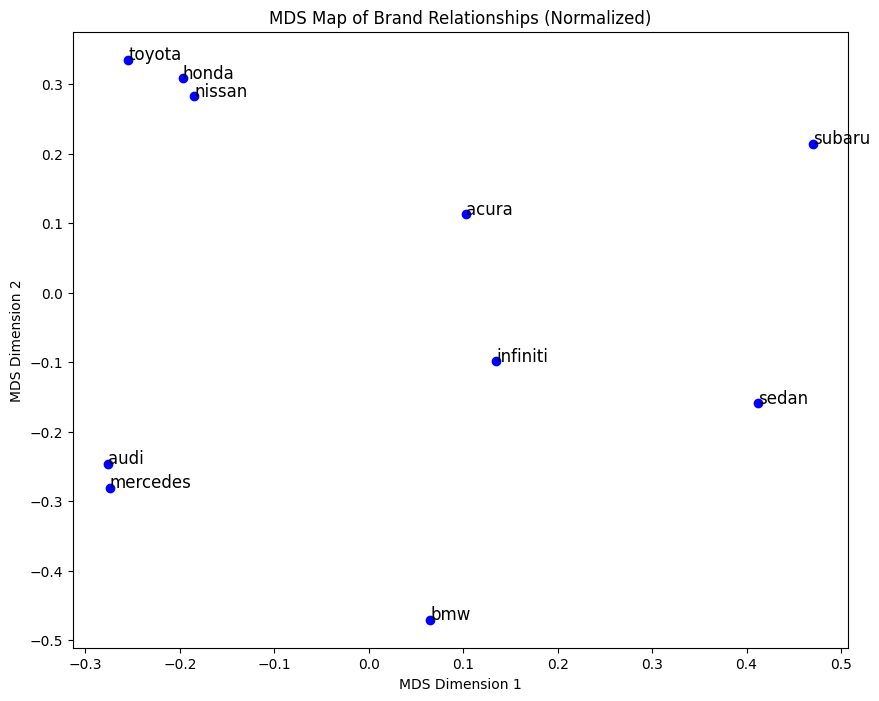

In [4]:
# Load brand name csv and comments csv
brand_names = pd.read_csv('Car_Models_Assignment_1_Data.csv',header=None, names=['Brand','Model'])
scraped_data = pd.read_csv('comments.csv')
message = scraped_data['message']

model_to_brand = dict(zip(brand_names['Model'].str.lower(), brand_names['Brand'].str.lower()))


brands = brand_names['Brand'].str.lower().unique().tolist()
models = brand_names['Model'].str.lower().unique().tolist()
all_keywords = brands + models

# i notice that there are some invalid brand names in the list so i will remove them

invalid_brands = [
    'hyndai', 'kia', 'hyundai,', 'hyndai kia', 'hyundai.', 'kia,',
    'kia.', 'nissan.', 'problem', 'seat', 'sedan',
    'toyata', 'volkwagen','car','cars']

all_keywords = [keyword for keyword in all_keywords if keyword not in invalid_brands]

# Remove invalid brands from brands
brands = [brand for brand in brands if brand not in invalid_brands]

def find_brands_in_message(message):
    if not isinstance(message, str):  # Check if the message is not a string
        return []  # Return an empty list if the message is not valid
    
    # Extract keywords (brands or models) from the message
    matched_keywords = set([word for word in message.lower().split() if word in all_keywords])
    
    # Replace models with their corresponding brands
    matched_brands = set()
    for keyword in matched_keywords:
        if keyword in model_to_brand:  # If it's a model, map it to the brand
            matched_brands.add(model_to_brand[keyword])
        elif keyword in brands:  # If it's already a brand, keep it
            matched_brands.add(keyword)
    
    return list(matched_brands) 

scraped_data['Mentioned_Brands'] = scraped_data['message'].apply(find_brands_in_message)

all_mentions = [brand for sublist in scraped_data['Mentioned_Brands'] for brand in sublist]
brand_counts = pd.Series(all_mentions).value_counts()

top_10_brands = brand_counts.head(10).index.tolist()

co_occurrence = pd.DataFrame(0, index=top_10_brands, columns=top_10_brands)

for brands_in_message in scraped_data['Mentioned_Brands']:
    for brand1, brand2 in combinations(brands_in_message, 2):
        if brand1 in top_10_brands and brand2 in top_10_brands:
            co_occurrence.at[brand1, brand2] += 1
            co_occurrence.at[brand2, brand1] += 1

individual_counts = brand_counts[top_10_brands]
total_messages = len(scraped_data)
expected = np.outer(individual_counts, individual_counts) / total_messages

# calculate lift
lift = co_occurrence / expected

# frequency Table
print("\nTop 10 Brands by Frequency:")
print(brand_counts.head(10))

# lift Table
print("\nLift Ratios:")
display(lift)

# MDS!!
# Normalize lift values
normalized_lift = (lift - lift.min().min()) / (lift.max().max() - lift.min().min())

# Compute dissimilarity as 1 - normalized lift
dissimilarity = 1 - normalized_lift

# Apply MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(dissimilarity)

# Plot the MDS Map
plt.figure(figsize=(10, 8))
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], color='blue')

for i, brand in enumerate(top_10_brands):
    plt.text(mds_coords[i, 0], mds_coords[i, 1], brand, fontsize=12)

plt.title("MDS Map of Brand Relationships (Normalized)")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.show()

# Task 3

### Executive Summary

From analyzing this forum, we see high association between Honda and Toyota (and Nissan). That is, in comments where Toyota is mentioned with another brand, it is most likely to be Honda (or Nissan) and vice versa. As both brands are Japanese, this makes sense intuitively. This relationship is visualized in the MDS map with Toyota and Honda taking space in an area close to each other. We see that both Toyota and Honda crack the top 10 in terms of brands most talked about, with Honda even in top 5. Even before diving into the sentiment analysis behind these mentions, the fact that people are likely to bring up the brands in discussions about entry level luxury performance sedans is a good thing from a brand relevancy standpoint.


# Task 4

In [5]:
from collections import Counter
import itertools

top_5_brands = pd.Series(itertools.chain.from_iterable(scraped_data['Mentioned_Brands'])).value_counts().head(5)

display(top_5_brands)

attribute_mapping = {
    "performance": ["acceleration", "pick-up", "speed", "horsepower"],
    "comfort": ["seating", "interior", "cabin", "ride quality"],
    "reliability": ["durability", "maintenance", "issues", "problems"],
    "price": ["cost", "value", "affordable", "expensive"],
    "fuel efficiency": ["mpg", "gas mileage", "fuel consumption"]
}


def extract_attributes(text):
    return [attr for attr, synonyms in attribute_mapping.items() 
            for synonym in synonyms if re.search(rf'\b{synonym}\b', text, re.IGNORECASE)]

scraped_data['attributes'] = scraped_data['message'].apply(lambda x: extract_attributes(str(x)))

#attribute mentions per brand
brand_attribute_counter = {brand: Counter() for brand in top_5_brands.index}

for _, row in scraped_data.iterrows():
    for brand in row['Mentioned_Brands']:
        if brand in top_5_brands.index:
            brand_attribute_counter[brand].update(row['attributes'])

#Display
attribute_table = pd.DataFrame(brand_attribute_counter).fillna(0).astype(int).T
attribute_table.columns.name = "Attributes"
print("Brand to Attribute Frequency Table:")
display(attribute_table)

bmw         1148
acura        456
honda        327
audi         317
infiniti     310
Name: count, dtype: int64

Brand to Attribute Frequency Table:


Attributes,performance,comfort,reliability,price,fuel efficiency
bmw,177,116,103,198,71
acura,95,58,28,80,12
honda,55,36,31,66,22
audi,57,55,32,45,18
infiniti,40,45,24,65,12


# Task 5

Some notable observations to Product Managers and Marketing Managers of these brands can be made here. 

#### BMW
For instance, BMW's performance is frequently discussed and even without sentiment analysis, we can assume that these are positive mentions - as poor performance is not something people usually bring up to discuss. However, 'reliability' is often brought up when there are issues with it specifically. Poor reliability is a frequent problem with luxury vehicles and a high count in reliability for BMW may not be as positive (although sentiment analysis needs to be done to confirm this). Therefore, product managers may want to look into getting further feedback from customers on what they are saying specifically about BMW's reliability and take action on that front.

The price of a BMW is apparently highly talked about. Again, whether these mentions imply that the product is good for the price or not is to be determined but the high count should indicate that the price of a BMW is a hot topic of discussion and marketing managers would want to dig deeper about how customers really feel about it. 

#### Acura
The most frequent attributes that show up when Acura is mentioned are 'performance' and 'price', while 'fuel efficiency' has a very low frequency. This could indicate that the fuel efficiency of an Acura is neither too good nor too bad and so discussions rarely mention it. Therefore, product managers can take this as an area of improvement for the brand to make it stand out amongst the competitors. 

For marketing managers, Acura seems to have counts of 'comfort' in the mentions when compared to its peers - campaigns can target this as a selling point.

#### Honda
Honda seems to have pretty even frequency counts across attributes and this could indicate that it is an all rounder when it comes to entry level luxury sedans. 

#### Audi
Audi's 'comfort' has a higher count than that of its peers and could be of interest to marketing managers as selling points for their campaign. It might also interest them to see what exactly about Audi's comfort is being talked about in these discussions. 

#### Infinity
Interestingly, Infiniti is the only brand in the top 5 where performance is not in the top 2 attributes. This may be of concern to Product Managers, finding out why people are not mentioning Inifiniti when performance is being discussed could be of interest. It's likely that Infiniti's performance does not stand out and doesn't get mentioned as a result. 


# Task 6

There has been a clear winner in terms of the brand being talked about the most for entry level luxury performance sedans and that brand is **BMW**. Just by looking at the frequency table, we see that it has almost double the count of the brand after it (Acura). Whether these mentions happen in a positive or negative light will require more investigative work specifically in sentiment analysis, nevertheless in terms of brand relevancy BMW is knocking it out of the park. Marketing managers will be happy to know that. 

Taking a further look, the MDS map shows us that BMW is on a league of its own. It has really low associations with any of the other brands, meaning that it has a strong brand identity. When people are talking about BMW, they are not likely to mention other brands to compare it to and this brings in strong value to the business in terms of **customer loyalty**. A customer who has always dreamed of buying a BMW for themselves is unlikely to change that dream with another brand. 